In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import os
import math
import copy
import seaborn as sns
import cv2
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = '../data/'
test_dir = 'segmented_test'
classes = sorted(os.listdir(data_dir + test_dir))
batch_size = 16

In [3]:
# normal test normalization
mean = [0.44947562, 0.46524084, 0.40037745]
std = [0.18456618, 0.16353698, 0.20014246]

data_transforms = {
        'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
        ])}

test_images = datasets.ImageFolder(os.path.join(data_dir, test_dir),
                    data_transforms['test'])

test_dataloader = DataLoader(test_images, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load('alexnet_pretrained.model', map_location=str(device)))
model.eval()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [5]:
def image_show(tensors, labels, preds):

    num_rows = 1
    num_cols = len(labels)
    fig = plt.figure(figsize=(num_cols, num_rows))
    i = 0
    for t in tensors:
        t = np.transpose(t.cpu().numpy(), (1, 2, 0))
        #t = np.asarray(std).mean() * t + np.asarray(mean).mean()
        t = np.clip(t, 0, 1)
    
        ax1 = fig.add_subplot(1, num_cols, i+1)
        fig.set_size_inches(18.5, 10.5)
        ax1.imshow(t, interpolation='none')
        ax1.axis('off')
        if preds[i] != labels[i]:
            ax1.set_title(classes[preds[i]][:10], size='x-small')
        i += 1
        
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.savefig(classes[labels[0]] + '_orig.jpg', bbox_inches='tight')


In [6]:
def occlusion(image, occluding_size, occluding_stride, model, classes, groundTruth):
    img = np.copy(image)
    height, width, _ = img.shape
    output_height = int(math.ceil((height-occluding_size) / occluding_stride + 1))
    output_width = int(math.ceil((width-occluding_size) / occluding_stride + 1))
    occluded_images = []
    for h in range(output_height):
        for w in range(output_width):
            #occluder region
            h_start = h * occluding_stride
            w_start = w * occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            
            input_image = copy.copy(img)
            input_image[h_start:h_end,w_start:w_end,:] =  0
            occluded_images.append(transforms.ToTensor()(Image.fromarray(input_image)))
            
    L = np.empty(output_height * output_width)
    L.fill(groundTruth)
    L = torch.from_numpy(L)
    tensor_images = torch.stack([img for img in occluded_images])
    dataset = torch.utils.data.TensorDataset(tensor_images, L) 
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=8) 

    heatmap = np.empty(0)
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = outputs.cpu()
        heatmap = np.concatenate((heatmap,outputs[0:outputs.size()[0], groundTruth].data.numpy()))
        
    return heatmap.reshape((output_height, output_width))

In [7]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):

        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        
        # forward completo, viene salvato il gradiente del target layer,
        # conv_out è l'uscita dal convolution target layer
        # model_output è l'uscita dall'ultimo layer della rete
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())

        # Target for backprop
        
        # Inizializzazione di one_hot_output come tensore tutto di 0 e in posizione [0][target_class]
        # assegna 1
        one_hot_output = torch.cuda.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        # Zero grads

        # reinizializzazione del gradiente
        # quando si fa backprogation il gradiente va reinizializzato se no le modifiche che verranno
        # apportate nella backpropagation andrebbero a sommarsi al gradiente calcolato precedentemente durante
        # il forward
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()

        # Backward pass with specified target	
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.cpu().data.numpy()[0]
        # Get convolution outputs
        target = conv_output.cpu().data.numpy()[0]

        # Get weights from gradients

        # I gradienti sono 1 x ogni neurone quindi viene eseguita una media
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        return cam

In [8]:
def show_class_activation_on_image(activation_map):
    #plt.imshow(activation_map, cmap="gray")
    #plt.show()
    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    #image_show(activation_heatmap)
    #img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    #img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    #image_show(np.uint8(255 * img_with_heatmap))
    
    return frame_extractor(activation_heatmap)

def frame_extractor(image):
    b, g, r = cv2.split(image)
    return cv2.merge((r, g, b))

In [9]:
grad_cam = GradCam(model, target_layer=11)
patch_size = 80
patch_stride = 10

In [10]:
cls = 9

C:\Users\aless\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


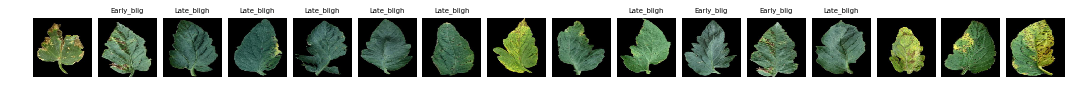

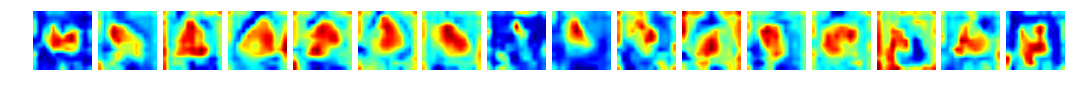

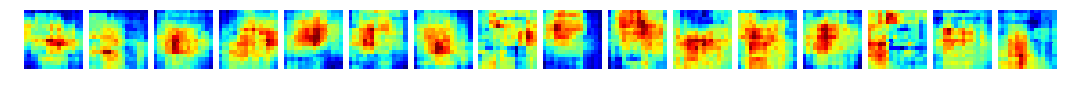

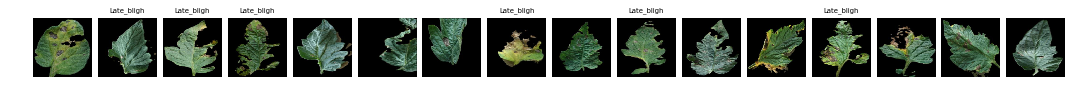

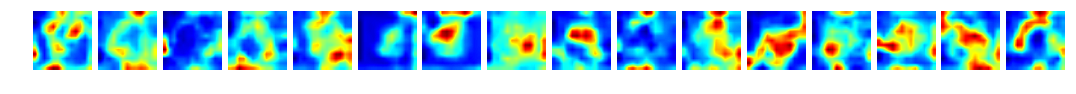

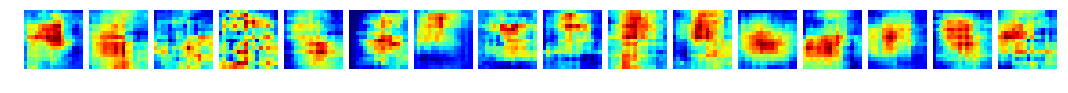

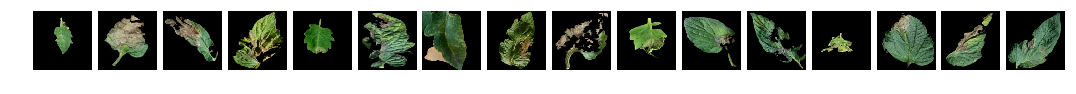

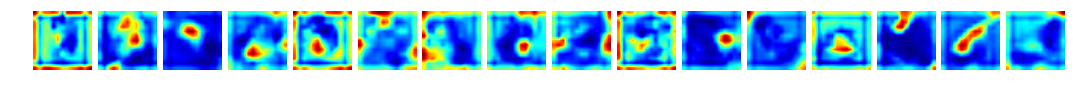

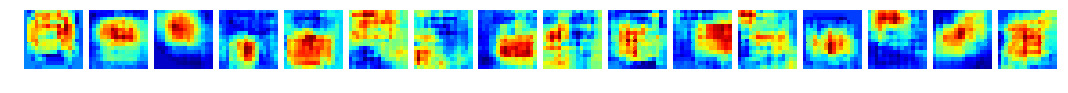

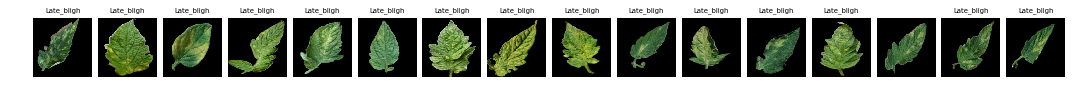

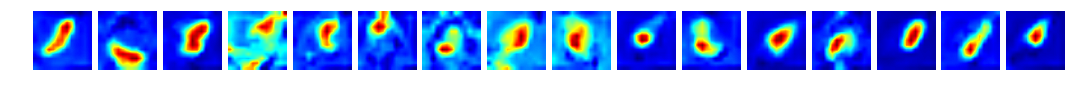

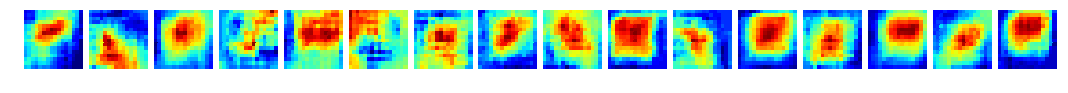

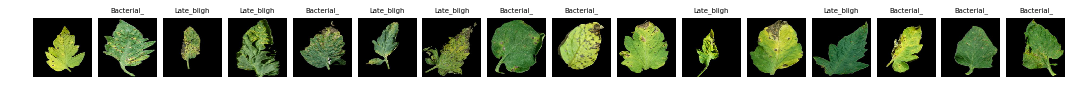

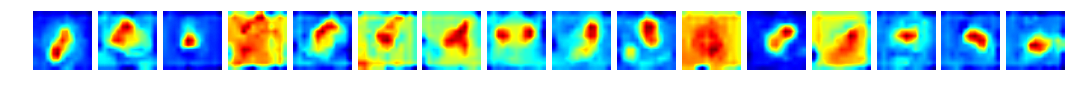

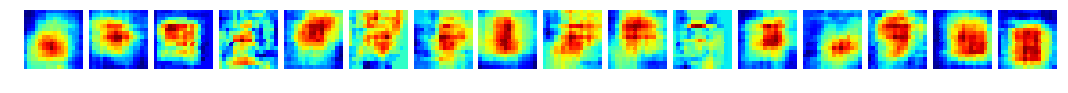

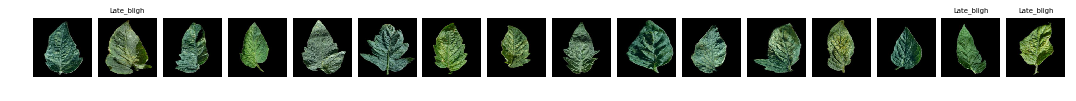

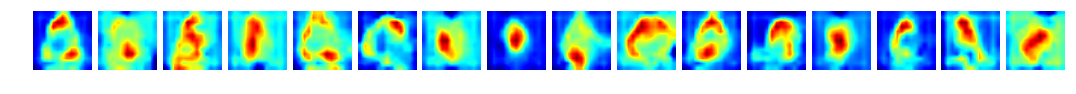

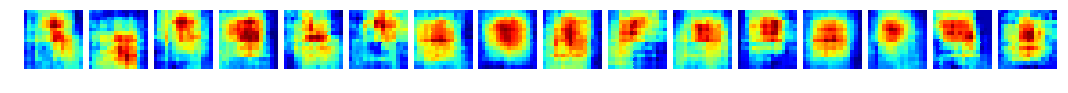

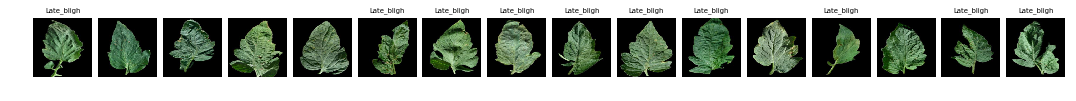

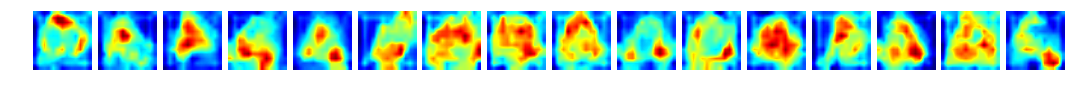

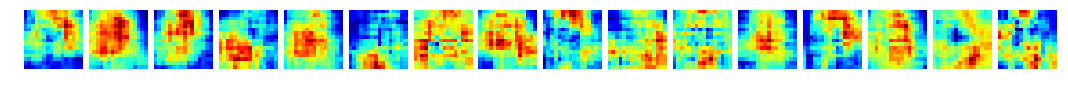

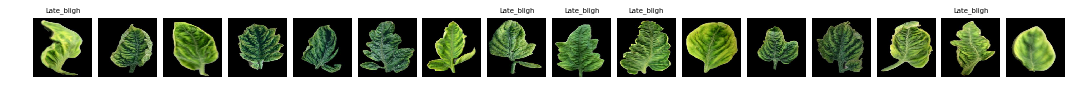

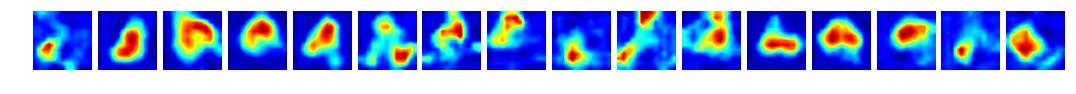

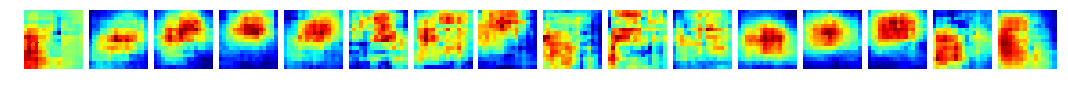

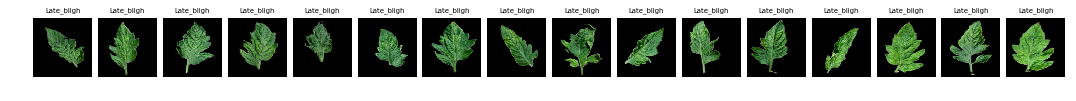

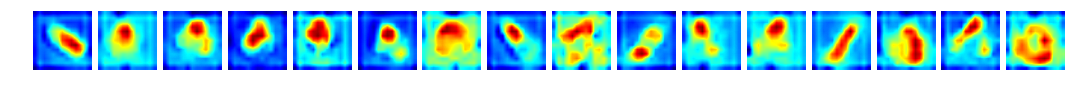

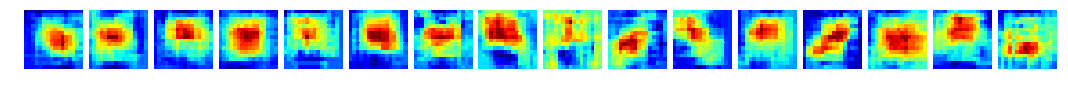

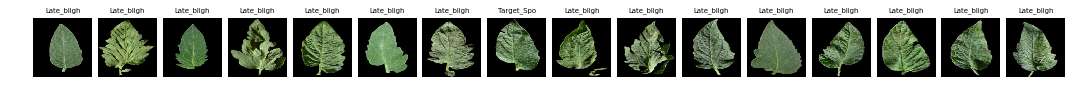

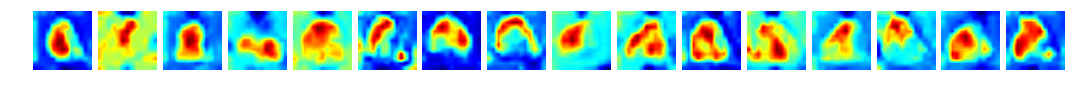

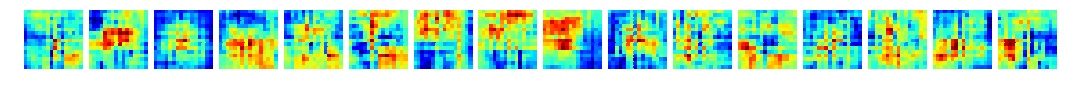

In [11]:
for cls in range(0,10):
    for inputs, labels in test_dataloader:
        if labels[0] != cls:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        image_show(inputs, labels, preds)
        
        cams = []
        for i in range(len(labels)):
            cam = grad_cam.generate_cam(inputs[i].unsqueeze_(0), labels[i])
            cams.append(show_class_activation_on_image(cam))

        fig = plt.figure(figsize=(len(labels), 1))
        for i in range(len(cams)):
            ax1 = fig.add_subplot(1, len(labels), i+1)
            ax1.axis('off')
            fig.set_size_inches(18.5, 10.5)
            ax1.imshow(cams[i], interpolation='none')

        plt.subplots_adjust(wspace=0.1, hspace=0)
        plt.savefig(classes[labels[0]] + '_cam.jpg', bbox_inches='tight')
        
        occludeds = []
        for i in range(len(labels)):
            ind = labels[i]
            img = transforms.ToPILImage()(inputs[i].cpu())
            occludeds.append(occlusion(img, patch_size, patch_stride, model, classes, ind))

        fig = plt.figure(figsize=(len(labels), 1))
        for i in range(len(occludeds)):
            ax1 = fig.add_subplot(1, len(labels), i+1)
            ax1.axis('off')
            fig.set_size_inches(18.5, 10.5)
            sns.heatmap(occludeds[i], cmap='jet_r', cbar=False, square=True, ax=ax1)

        plt.subplots_adjust(wspace=0.1, hspace=0)
        plt.savefig(classes[labels[0]] + '_occ.jpg', bbox_inches='tight')
        
        break